In [26]:
import json
import os
import numpy
import pandas
import sys
import importlib

from datetime import date
from os import path
from dotenv import load_dotenv

sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))

from bespoke.inventory.analysis.shared import download_util
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util
from bespoke.inventory.analysis import inventory_cogs_util as cogs_util

load_dotenv(verbose=True)
engine = download_util.get_bigquery_engine('bigquery://bespoke-financial/ProdMetrcData')

def _reload_libs():
    importlib.reload(util)
    importlib.reload(valuations_util)
    importlib.reload(download_util)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
COMPANY_NAME = 'BBF'
COMPANY_IDENTIFIER = 'BBF'
TRANSFER_PACKAGES_START_DATE = '2019-01-01'
SALES_TRANSACTIONS_START_DATE = '2019-01-01'
ANALYSIS_PARAMS = {
    'sold_threshold': 1.0,
    'find_parent_child_relationships': False,
    'use_prices_to_fill_missing_incoming': True,
    'external_pricing_data_config': {
        'category_to_fixed_prices': {
            'Buds': {
                'grams': 10.0
            },
            'Infused (edible)': {
                'each': 4.0
            },
            'Infused (non-edible)': {
                'each': 3.0
            },
            'Vape Product': {
                'each': 3.0
            },
            'Concentrate (Bulk)': {
                'grams': 6.0
            },
            'Concentrate': {
                'grams': 7.0
            },
            'Raw Pre-Rolls': {
                'grams': 7.0,
                'pounds': 80.0
            },
            'Shake/Trim (by strain)': {
                'grams': 8.0
            }
        }
    }
}
TODAY_DATE = date.today()
print('Today is {}'.format(TODAY_DATE))

Today is 2021-11-11


In [7]:
# Download packages, sales transactions, incoming / outgoing tranfers
q = download_util.Query(
    inventory_dates=[],
    transfer_packages_start_date=TRANSFER_PACKAGES_START_DATE,
    sales_transactions_start_date=SALES_TRANSACTIONS_START_DATE,
    company_identifier=COMPANY_IDENTIFIER,
    company_name=COMPANY_NAME,
)

all_dataframes_dict = download_util.get_dataframes_for_analysis(q, engine)

In [16]:
_reload_libs()

q.inventory_dates = download_util.get_inventory_dates(
    all_dataframes_dict, TODAY_DATE)
d = util.Download()
sql_helper = util.BigQuerySQLHelper(engine)
d.download_dataframes(
    all_dataframes_dict=all_dataframes_dict,
    sql_helper=sql_helper
)

In [17]:
_reload_libs()

id_to_history = util.get_histories(d, ANALYSIS_PARAMS)
util.print_counts(id_to_history)
util.create_inventory_xlsx(id_to_history, q, params=ANALYSIS_PARAMS)

Only outgoing: 43
Only incoming: 210
Sold packages missing incoming_pkg: 0 (0.00% of packages)
Incoming packages missing price 5 (0.51% of incoming packages)
In and out: 25
In and sold at least once 749
In and sold many times 725

 Num parent packages: 0
 num matched child packages: 240
Total pkgs: 1015
Wrote result to out/BBF_inventory_by_month.xls
Excluded 43 / 1015 packages from consideration (4.24%)
  MISSING_INCOMING: 43 times


In [29]:
_reload_libs()

   
computed_resp = util.compute_inventory_across_dates(
    d, q.inventory_dates, ANALYSIS_PARAMS
)

today_date_str = TODAY_DATE.strftime('%d/%m/%Y')
#INVENTORY_DATES = [today_date_str]
util.compare_computed_vs_actual_inventory(
    computed=computed_resp['date_to_computed_inventory_dataframe'][today_date_str],
    actual=d.inventory_packages_dataframe,
    compare_options={
        'num_errors_to_show': 10,
        'accept_computed_when_sold_out': True
    }
)


On 06/30/2020 # packages in inventory: 49, valuation cost: 83699.64
On 07/31/2020 # packages in inventory: 81, valuation cost: 87629.72
On 08/31/2020 # packages in inventory: 74, valuation cost: 38127.67
On 09/30/2020 # packages in inventory: 73, valuation cost: 21499.65
On 10/31/2020 # packages in inventory: 80, valuation cost: 16601.2
On 11/30/2020 # packages in inventory: 89, valuation cost: 41555.32
On 12/31/2020 # packages in inventory: 74, valuation cost: 45550.24
On 01/31/2021 # packages in inventory: 107, valuation cost: 60839.84
On 02/28/2021 # packages in inventory: 127, valuation cost: 50388.63
On 03/31/2021 # packages in inventory: 138, valuation cost: 40693.55
On 04/30/2021 # packages in inventory: 159, valuation cost: 33180.6
On 05/31/2021 # packages in inventory: 177, valuation cost: 23810.41
On 06/30/2021 # packages in inventory: 209, valuation cost: 49623.0
On 07/31/2021 # packages in inventory: 189, valuation cost: 39759.99
On 08/31/2021 # packages in inventory: 233, 

In [27]:
_reload_libs()

# Do the COGS summary too
topdown_cogs_rows = cogs_util.create_top_down_cogs_summary_for_all_dates(
    d, ANALYSIS_PARAMS
)

bottomsup_cogs_rows = cogs_util.create_cogs_summary_for_all_dates(
  id_to_history, ANALYSIS_PARAMS
)
cogs_util.write_cogs_xlsx(
    topdown_cogs_rows=topdown_cogs_rows, 
    bottoms_up_cogs_rows=bottomsup_cogs_rows,
    company_name=COMPANY_NAME
)

Wrote result to out/BBF_cogs_summary.xls


Plotting sales revenue vs cost-based inventory valuation for dates: ['06/30/2020', '07/31/2020', '08/31/2020', '09/30/2020', '10/31/2020', '11/30/2020', '12/31/2020', '01/31/2021', '02/28/2021', '03/31/2021', '04/30/2021', '05/31/2021', '06/30/2021', '07/31/2021', '08/31/2021', '09/30/2021', '10/31/2021', '11/11/2021']


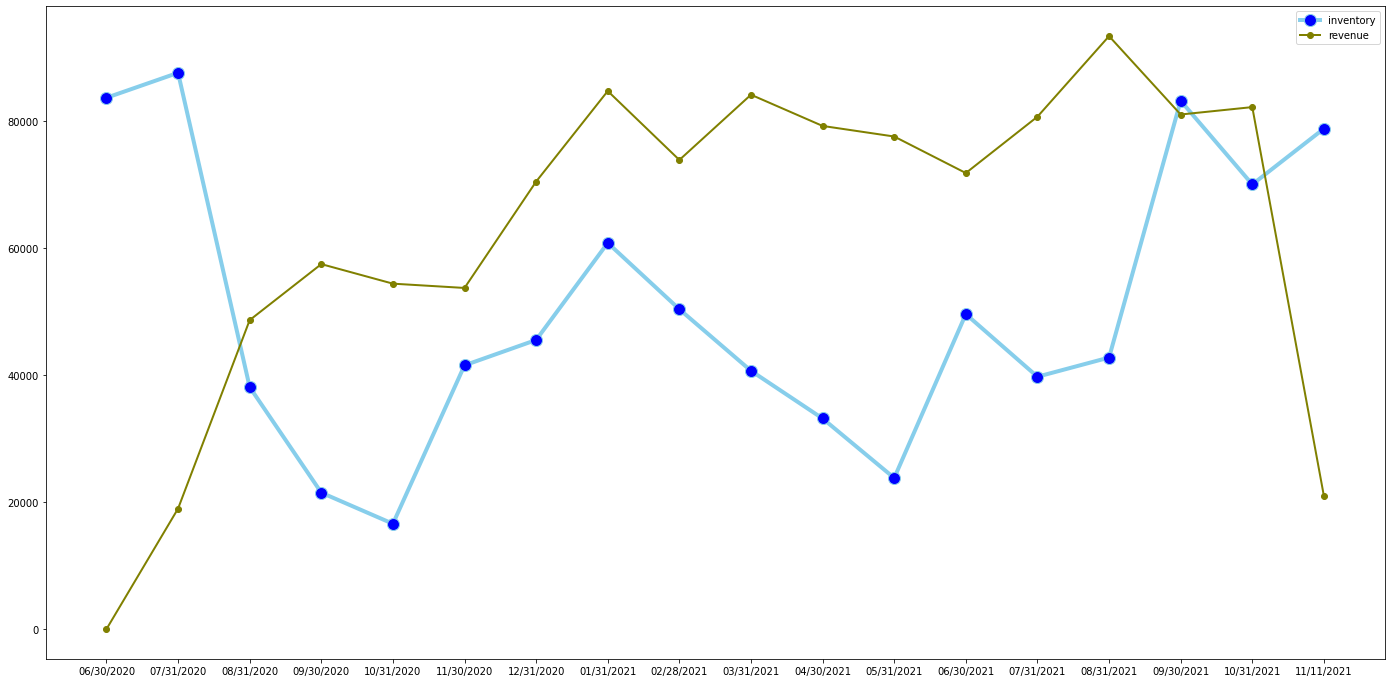

In [32]:
_reload_libs()

print(f'Plotting sales revenue vs cost-based inventory valuation for dates: {q.inventory_dates}')
valuations_util.plot_inventory_and_revenue(
    q=q,
    sales_receipts_dataframe=d.sales_receipts_dataframe,
    inventory_valuations=computed_resp['inventory_valuations']
)

In [ ]:
#### DEBUG
util.run_orphan_analysis(d, id_to_history)

In [ ]:
# For debugging individual package histories
_reload_libs()

PACKAGE_IDS = [
  '862838'
]

util.analyze_specific_package_histories(
    d, package_id_to_actual_row, PACKAGE_IDS, params=ANALYSIS_PARAMS)